In [1]:
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

Téléchargez et extrayez le jeu de données TCGA de l'UCI :

In [2]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

La KMeansclasse dans scikit-learn nécessite un tableau NumPy comme argument. Le package NumPy a une fonction d'assistance pour charger les données du fichier texte en mémoire sous forme de tableaux NumPy :

In [3]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = np.genfromtxt(
     datafile,
     delimiter=",",
     usecols=range(1, 20532),
     skip_header=1
)

true_label_names = np.genfromtxt(
     labels_file,
     delimiter=",",
     usecols=(1,),
     skip_header=1,
     dtype="str"
)

Consultez les trois premières colonnes de données pour les cinq premiers échantillons ainsi que les étiquettes des cinq premiers échantillons :

In [4]:
data[:5, :3]

array([[0.        , 2.01720929, 3.26552691],
       [0.        , 0.59273209, 1.58842082],
       [0.        , 3.51175898, 4.32719872],
       [0.        , 3.66361787, 4.50764878],
       [0.        , 2.65574107, 2.82154696]])

In [5]:
true_label_names[:5]

array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype='<U4')

La datavariable contient toutes les valeurs d'expression génique des 20,531gènes. Ce true_label_namessont les types de cancer pour chacun des 881échantillons. Le premier enregistrement de datacorrespond à la première étiquette de true_labels.


Les étiquettes sont des chaînes contenant des abréviations de types de cancer :


BRCA: Carcinome invasif du sein

COAD: Adénocarcinome du côlon

KIRC: Carcinome rénal à cellules claires du rein

LUAD: Adénocarcinome pulmonaire

PRAD: Adénocarcinome de la prostate


Pour utiliser ces étiquettes dans les méthodes d'évaluation, vous devez d'abord convertir les abréviations en nombres entiers avec LabelEncoder:

In [6]:
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)

true_labels[:5]

array([4, 3, 4, 4, 0], dtype=int64)

Puisque le label_encodera été ajusté aux données, vous pouvez voir les classes uniques représentées à l'aide de .classes_. Stockez la longueur du tableau dans la variable n_clusterspour une utilisation ultérieure :

In [7]:
label_encoder.classes_

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype='<U4')

In [8]:
n_clusters = len(label_encoder.classes_)

Dans les pipelines d'apprentissage automatique pratiques, il est courant que les données subissent plusieurs séquences de transformations avant d'être intégrées à un algorithme de clustering. Vous avez appris l'importance de l'une de ces étapes de transformation, la mise à l'échelle des fonctionnalités, plus tôt dans ce didacticiel. Une technique de transformation de données tout aussi importante est la réduction de la dimensionnalité , qui réduit le nombre d'entités dans l'ensemble de données en les supprimant ou en les combinant.

Les techniques de réduction de la dimensionnalité aident à résoudre un problème avec les algorithmes d'apprentissage automatique connu sous le nom de malédiction de la dimensionnalité . En bref, à mesure que le nombre de fonctionnalités augmente, l' espace des fonctionnalités devient rare. Cette rareté rend difficile pour les algorithmes de trouver des objets de données proches les uns des autres dans un espace de dimension supérieure. Étant donné que l'ensemble de données d'expression génique a plus de 20,000fonctionnalités, il se qualifie comme un excellent candidat pour la réduction de la dimensionnalité.

L'analyse en composantes principales (ACP) est l'une des nombreuses techniques de réduction de dimensionnalité. PCA transforme les données d'entrée en les projetant dans un nombre inférieur de dimensions appelées composants . Les composants capturent la variabilité des données d'entrée grâce à une combinaison linéaire des caractéristiques des données d'entrée.

Le bloc de code suivant vous présente le concept des pipelines scikit-learn . La Pipelineclasse scikit-learn est une implémentation concrète de l'idée abstraite d'un pipeline d'apprentissage automatique.

Vos données d'expression génique ne sont pas au format optimal pour la KMeansclasse, vous devrez donc créer un pipeline de prétraitement . Le pipeline implémentera une alternative à la StandardScalerclasse appelée MinMaxScalerpour la mise à l'échelle des fonctionnalités. Vous utilisez MinMaxScalerlorsque vous ne supposez pas que la forme de toutes vos caractéristiques suit une distribution normale.

L'étape suivante de votre pipeline de prétraitement implémentera la PCAclasse pour effectuer la réduction de dimensionnalité:



In [9]:
preprocessor = Pipeline(
     [
         ("scaler", MinMaxScaler()),
         ("pca", PCA(n_components=2, random_state=42)),
     ]
)

Maintenant que vous avez créé un pipeline pour traiter les données, vous allez créer un pipeline distinct pour effectuer le clustering k -means. Vous remplacerez les arguments par défaut suivants de la KMeansclasse :

init : vous utiliserez à la "k-means++"place de "random"pour vous assurer que les centroïdes sont initialisés avec une certaine distance entre eux. Dans la plupart des cas, ce sera une amélioration par rapport à "random".

n_init : vous augmenterez le nombre d'initialisations pour vous assurer de trouver une solution stable.

max_iter : vous augmenterez le nombre d'itérations par initialisation pour vous assurer que k -means convergera.

Construisez le pipeline de clustering k -means avec des arguments définis par l'utilisateur dans le KMeansconstructeur :



In [10]:
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=n_clusters,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
)

La Pipelineclasse peut être chaînée pour former un pipeline plus grand. Construisez un pipeline de clustering k -means de bout en bout en passant les pipelines "preprocessor"et "clusterer"àPipeline :

In [11]:
pipe = Pipeline(
     [
         ("preprocessor", preprocessor),
         ("clusterer", clusterer)
     ]
)

L'appel .fit() avec datacomme argument exécute toutes les étapes du pipeline sur data:

In [12]:
pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

Le pipeline effectue toutes les étapes nécessaires pour exécuter le clustering k -means sur les données d'expression génique ! Selon votre Python REPL, .fit()peut imprimer un résumé du pipeline. Les objets définis dans les pipelines sont accessibles à l'aide de leur nom d'étape.

Évaluez les performances en calculant le coefficient de silhouette :

In [13]:
preprocessed_data = pipe["preprocessor"].transform(data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.5118775528450312

Calculez également l'ARI, car les étiquettes de cluster de vérité terrain sont disponibles :

In [14]:
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

Comme mentionné précédemment, l'échelle de chacune de ces métriques de performance de clustering va de -1 à 1. Un coefficient de silhouette de 0 indique que les clusters se chevauchent de manière significative, et un coefficient de silhouette de 1 indique que les clusters sont bien séparés. Un score ARI de 0 indique que les étiquettes de cluster sont attribuées au hasard, et un score ARI de 1 signifie que les vraies étiquettes et les étiquettes prédites forment des clusters identiques.

Puisque vous avez spécifié n_components=2dans l'étape PCA du pipeline de clustering k -means, vous pouvez également visualiser les données dans le contexte des vraies étiquettes et des étiquettes prédites. Tracez les résultats à l'aide d'un DataFrame pandas et de la bibliothèque de traçage Seaborn :

C:\Users\Zakaria\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


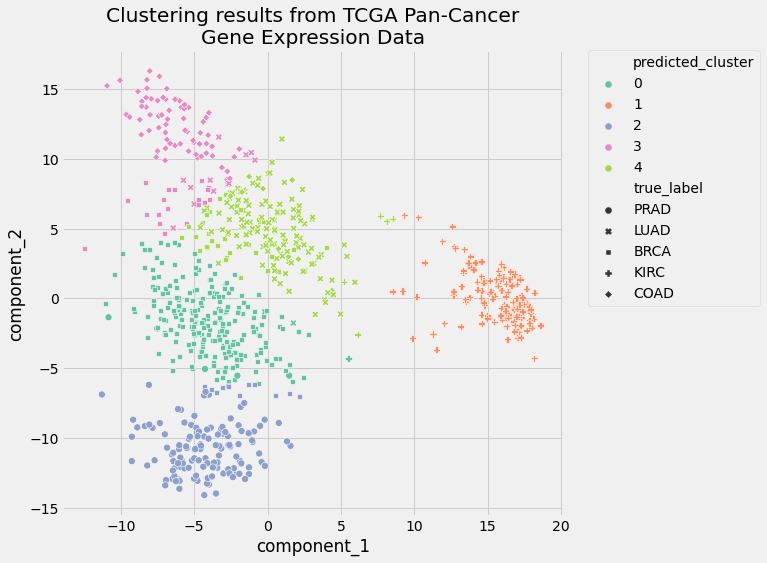

In [15]:
pcadf = pd.DataFrame(
     pipe["preprocessor"].transform(data),
     columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
     "component_1",
     "component_2",
     s=50,
     data=pcadf,
     hue="predicted_cluster",
     style="true_label",
     palette="Set2",
)

scat.set_title("Clustering results from TCGA Pan-Cancer\nGene Expression Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()